In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import numpy as np
import sys
sys.path.append("./../code/")
from population_model import massModel,truncatedNormal
from tqdm import tqdm
from scipy.stats import gaussian_kde

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [17]:
nn_data = az.from_netcdf("../data/output_dynamicInjections.cdf")
nnA_data = az.from_netcdf("../data/output_dynamicInjections_altNetwork_03.cdf")
nnB_data = az.from_netcdf("../data/output_dynamicInjections_moreHopeless_05.cdf")

inj_data = az.from_netcdf("../data/output_standardInjections.cdf")
injA_data = az.from_netcdf("../data/output_standardInjections_injectionSubsetA.cdf")
injB_data = az.from_netcdf("../data/output_standardInjections_injectionSubsetB.cdf")

In [18]:
nn_samps = nn_data.posterior.stack(draws=("chain", "draw"))
nnA_samps = nnA_data.posterior.stack(draws=("chain", "draw"))
nnB_samps = nnB_data.posterior.stack(draws=("chain", "draw"))

inj_samps = inj_data.posterior.stack(draws=("chain", "draw"))
injA_samps = injA_data.posterior.stack(draws=("chain", "draw"))
injB_samps = injB_data.posterior.stack(draws=("chain", "draw"))

In [4]:
def get_interval_string(xs):
    
    med = np.median(xs)
    upperError = np.quantile(xs, 0.95) - med
    lowerError = med - np.quantile(xs, 0.05)
    
    intervalString = r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(med,upperError,lowerError)
    return intervalString

def plot_contour_data(ax,
                      xvals,
                      yvals,
                      xmin,
                      xmax,
                      ymin,
                      ymax,
                      color,
                      resolution=50,
                      bw='scott',
                      ls=None):
    
    kde = gaussian_kde([xvals, yvals],bw_method=0.25)
    xgrid = np.linspace(xmin, xmax, resolution)
    ygrid = np.linspace(ymin, ymax, resolution-1)
    X, Y = np.meshgrid(xgrid, ygrid)
    kde_vals = kde([X.reshape(-1), Y.reshape(-1)])
    kde_vals_2d = kde_vals.reshape(ygrid.size, xgrid.size)

    kde_vals_sorted = np.sort(kde_vals)[::-1]
    cdf_vals = np.cumsum(kde_vals_sorted)
    cdf_vals /= cdf_vals[-1]

    c95 = np.interp(0.95, cdf_vals, kde_vals_sorted)
    c50 = np.interp(0.50, cdf_vals, kde_vals_sorted)
    
    if ls:
        ax.contour(xgrid,ygrid,kde_vals_2d,levels=(c95,c50),colors=color,linewidths=1.5,linestyles=ls)
    else:
        ax.contour(xgrid,ygrid,kde_vals_2d,levels=(c95,c50),colors=color,linewidths=1.5)
        
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

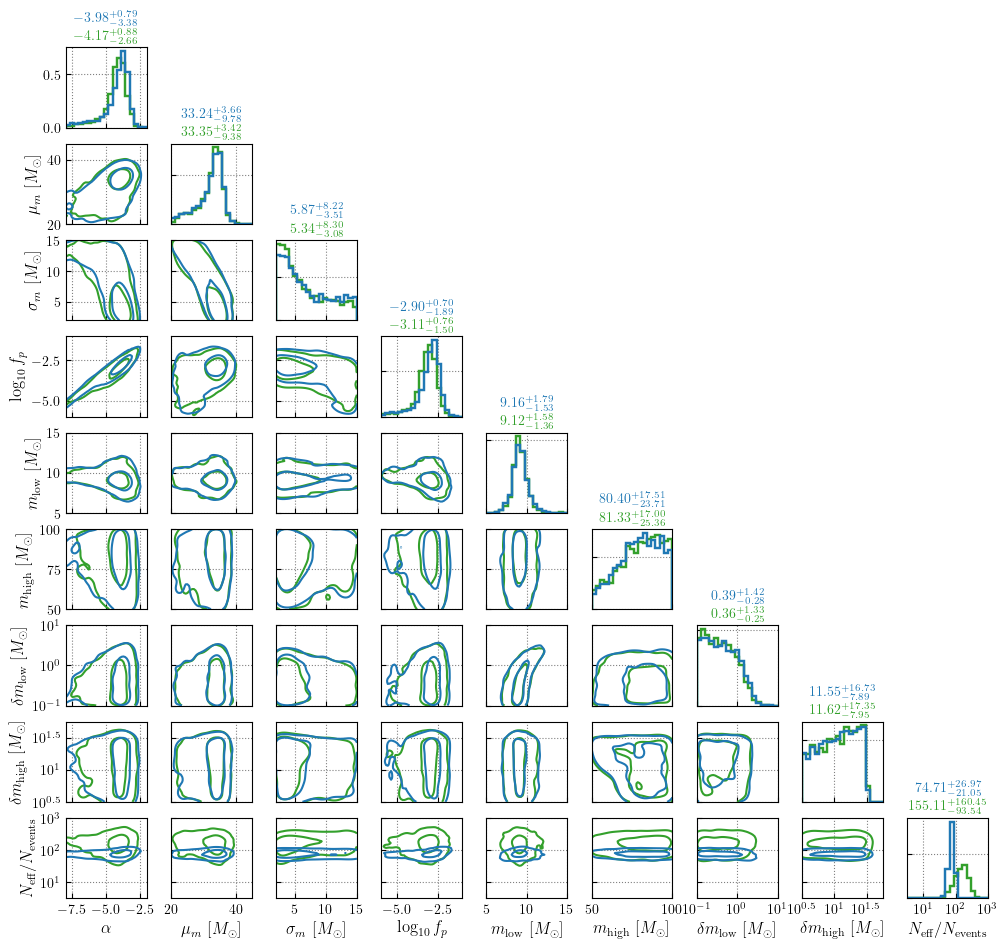

In [14]:
fig = plt.figure(figsize=(14*0.85,13*0.85))

alphas_inj = inj_samps.alpha.values
mu_m1s_inj = inj_samps.mu_m1.values
sig_m1s_inj = inj_samps.sig_m1.values
log_f_peaks_inj = inj_samps.log_f_peak.values
mMins_inj = inj_samps.mMin.values
mMaxs_inj = inj_samps.mMax.values
log_dmMins_inj = inj_samps.log_dmMin.values
log_dmMaxs_inj = inj_samps.log_dmMax.values
Neffs_inj = np.log10(inj_samps.nEff_inj_per_event.values)

alphas_nn = nn_samps.alpha.values
mu_m1s_nn = nn_samps.mu_m1.values
sig_m1s_nn = nn_samps.sig_m1.values
log_f_peaks_nn = nn_samps.log_f_peak.values
mMins_nn = nn_samps.mMin.values
mMaxs_nn = nn_samps.mMax.values
log_dmMins_nn = nn_samps.log_dmMin.values
log_dmMaxs_nn = nn_samps.log_dmMax.values
Neffs_nn = np.log10(nn_samps.nEff_inj_per_event.values)

alpha_min,alpha_max = -8,-2
mu_m1_min,mu_m1_max = 20,45
sig_m1_min,sig_m1_max = 2,15
log_f_peak_min,log_f_peak_max = -6,-1
mMin_min,mMin_max = 5,15
mMax_min,mMax_max = 50,100
log_dmMin_min,log_dmMin_max = -1,1
log_dmMax_min,log_dmMax_max = 0.5,1.75
Neff_min,Neff_max = 0.5,3

###########
# COLUMN 1
###########

ax = fig.add_subplot(9,9,1)
ax.hist(alphas_inj,density=True,histtype='step',bins=np.linspace(alpha_min,alpha_max,20),color=cnsbh,lw=1.75)
ax.hist(alphas_nn,density=True,histtype='step',bins=np.linspace(alpha_min,alpha_max,20),color=cbbh,lw=1.75)
ax.set_xlim(alpha_min,alpha_max)
ax.set_xticklabels([])
ax.text(0.5,1.1,get_interval_string(alphas_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(alphas_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,10)
plot_contour_data(ax,alphas_inj,mu_m1s_inj,alpha_min,alpha_max,mu_m1_min,mu_m1_max,cnsbh)
plot_contour_data(ax,alphas_nn,mu_m1s_nn,alpha_min,alpha_max,mu_m1_min,mu_m1_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\mu_m$ [$M_\odot$]")

ax = fig.add_subplot(9,9,19)
plot_contour_data(ax,alphas_inj,sig_m1s_inj,alpha_min,alpha_max,sig_m1_min,sig_m1_max,cnsbh)
plot_contour_data(ax,alphas_nn,sig_m1s_nn,alpha_min,alpha_max,sig_m1_min,sig_m1_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\sigma_m$ [$M_\odot$]")

ax = fig.add_subplot(9,9,28)
plot_contour_data(ax,alphas_inj,log_f_peaks_inj,alpha_min,alpha_max,log_f_peak_min,log_f_peak_max,cnsbh)
plot_contour_data(ax,alphas_nn,log_f_peaks_nn,alpha_min,alpha_max,log_f_peak_min,log_f_peak_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\log_{10} f_p$")

ax = fig.add_subplot(9,9,37)
plot_contour_data(ax,alphas_inj,mMins_inj,alpha_min,alpha_max,mMin_min,mMin_max,cnsbh)
plot_contour_data(ax,alphas_nn,mMins_nn,alpha_min,alpha_max,mMin_min,mMin_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$m_\mathrm{low}$ [$M_\odot$]")

ax = fig.add_subplot(9,9,46)
plot_contour_data(ax,alphas_inj,mMaxs_inj,alpha_min,alpha_max,mMax_min,mMax_max,cnsbh)
plot_contour_data(ax,alphas_nn,mMaxs_nn,alpha_min,alpha_max,mMax_min,mMax_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$m_\mathrm{high}$ [$M_\odot$]")

ax = fig.add_subplot(9,9,55)
plot_contour_data(ax,alphas_inj,log_dmMins_inj,alpha_min,alpha_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,alphas_nn,log_dmMins_nn,alpha_min,alpha_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticks([-1,0,1])
ax.set_yticklabels(["$10^{-1}$","$10^{0}$","$10^{1}$"])
ax.set_ylabel(r"$\delta m_\mathrm{low}$ [$M_\odot$]")

ax = fig.add_subplot(9,9,64)
plot_contour_data(ax,alphas_inj,log_dmMaxs_inj,alpha_min,alpha_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,alphas_nn,log_dmMaxs_nn,alpha_min,alpha_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticks([0.5,1,1.5])
ax.set_yticklabels(["$10^{0.5}$","$10^{1}$","$10^{1.5}$"])
ax.set_ylabel(r"$\delta m_\mathrm{high}$ [$M_\odot$]")

ax = fig.add_subplot(9,9,73)
plot_contour_data(ax,alphas_inj,Neffs_inj,alpha_min,alpha_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,alphas_nn,Neffs_nn,alpha_min,alpha_max,Neff_min,Neff_max,cbbh)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")
ax.set_yticks([1,2,3])
ax.set_yticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
#ax.set_ylabel(r"$\delta m_\mathrm{high}$ [$M_\odot$]")

###########
# COLUMN 2
###########

ax = fig.add_subplot(9,9,11)
ax.hist(mu_m1s_inj,density=True,histtype='step',bins=np.linspace(mu_m1_min,mu_m1_max,20),color=cnsbh,lw=1.75)
ax.hist(mu_m1s_nn,density=True,histtype='step',bins=np.linspace(mu_m1_min,mu_m1_max,20),color=cbbh,lw=1.75)
ax.set_xlim(mu_m1_min,mu_m1_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(mu_m1s_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(mu_m1s_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,20)
plot_contour_data(ax,mu_m1s_inj,sig_m1s_inj,mu_m1_min,mu_m1_max,sig_m1_min,sig_m1_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,sig_m1s_nn,mu_m1_min,mu_m1_max,sig_m1_min,sig_m1_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,29)
plot_contour_data(ax,mu_m1s_inj,log_f_peaks_inj,mu_m1_min,mu_m1_max,log_f_peak_min,log_f_peak_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,log_f_peaks_nn,mu_m1_min,mu_m1_max,log_f_peak_min,log_f_peak_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,38)
plot_contour_data(ax,mu_m1s_inj,mMins_inj,mu_m1_min,mu_m1_max,mMin_min,mMin_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,mMins_nn,mu_m1_min,mu_m1_max,mMin_min,mMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,47)
plot_contour_data(ax,mu_m1s_inj,mMaxs_inj,mu_m1_min,mu_m1_max,mMax_min,mMax_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,mMaxs_nn,mu_m1_min,mu_m1_max,mMax_min,mMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,56)
plot_contour_data(ax,mu_m1s_inj,log_dmMins_inj,mu_m1_min,mu_m1_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,log_dmMins_nn,mu_m1_min,mu_m1_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,65)
plot_contour_data(ax,mu_m1s_inj,log_dmMaxs_inj,mu_m1_min,mu_m1_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,log_dmMaxs_nn,mu_m1_min,mu_m1_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,74)
plot_contour_data(ax,mu_m1s_inj,Neffs_inj,mu_m1_min,mu_m1_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,mu_m1s_nn,Neffs_nn,mu_m1_min,mu_m1_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\mu_m$ [$M_\odot$]")

###########
# COLUMN 3
###########

ax = fig.add_subplot(9,9,21)
ax.hist(sig_m1s_inj,density=True,histtype='step',bins=np.linspace(sig_m1_min,sig_m1_max,20),color=cnsbh,lw=1.75)
ax.hist(sig_m1s_nn,density=True,histtype='step',bins=np.linspace(sig_m1_min,sig_m1_max,20),color=cbbh,lw=1.75)
ax.set_xlim(sig_m1_min,sig_m1_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(sig_m1s_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(sig_m1s_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,30)
plot_contour_data(ax,sig_m1s_inj,log_f_peaks_inj,sig_m1_min,sig_m1_max,log_f_peak_min,log_f_peak_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,log_f_peaks_nn,sig_m1_min,sig_m1_max,log_f_peak_min,log_f_peak_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,39)
plot_contour_data(ax,sig_m1s_inj,mMins_inj,sig_m1_min,sig_m1_max,mMin_min,mMin_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,mMins_nn,sig_m1_min,sig_m1_max,mMin_min,mMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,48)
plot_contour_data(ax,sig_m1s_inj,mMaxs_inj,sig_m1_min,sig_m1_max,mMax_min,mMax_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,mMaxs_nn,sig_m1_min,sig_m1_max,mMax_min,mMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,57)
plot_contour_data(ax,sig_m1s_inj,log_dmMins_inj,sig_m1_min,sig_m1_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,log_dmMins_nn,sig_m1_min,sig_m1_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,66)
plot_contour_data(ax,sig_m1s_inj,log_dmMaxs_inj,sig_m1_min,sig_m1_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,log_dmMaxs_nn,sig_m1_min,sig_m1_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,75)
plot_contour_data(ax,sig_m1s_inj,Neffs_inj,sig_m1_min,sig_m1_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,sig_m1s_nn,Neffs_nn,sig_m1_min,sig_m1_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\sigma_m$ [$M_\odot$]")

###########
# COLUMN 4
###########

ax = fig.add_subplot(9,9,31)
ax.hist(log_f_peaks_inj,density=True,histtype='step',bins=np.linspace(log_f_peak_min,log_f_peak_max,20),color=cnsbh,lw=1.75)
ax.hist(log_f_peaks_nn,density=True,histtype='step',bins=np.linspace(log_f_peak_min,log_f_peak_max,20),color=cbbh,lw=1.75)
ax.set_xlim(log_f_peak_min,log_f_peak_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(log_f_peaks_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(log_f_peaks_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,40)
plot_contour_data(ax,log_f_peaks_inj,mMins_inj,log_f_peak_min,log_f_peak_max,mMin_min,mMin_max,cnsbh)
plot_contour_data(ax,log_f_peaks_nn,mMins_nn,log_f_peak_min,log_f_peak_max,mMin_min,mMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,49)
plot_contour_data(ax,log_f_peaks_inj,mMaxs_inj,log_f_peak_min,log_f_peak_max,mMax_min,mMax_max,cnsbh)
plot_contour_data(ax,log_f_peaks_nn,mMaxs_nn,log_f_peak_min,log_f_peak_max,mMax_min,mMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,58)
plot_contour_data(ax,log_f_peaks_inj,log_dmMins_inj,log_f_peak_min,log_f_peak_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,log_f_peaks_nn,log_dmMins_nn,log_f_peak_min,log_f_peak_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,67)
plot_contour_data(ax,log_f_peaks_inj,log_dmMaxs_inj,log_f_peak_min,log_f_peak_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,log_f_peaks_nn,log_dmMaxs_nn,log_f_peak_min,log_f_peak_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,76)
plot_contour_data(ax,log_f_peaks_inj,Neffs_inj,log_f_peak_min,log_f_peak_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,log_f_peaks_nn,Neffs_nn,log_f_peak_min,log_f_peak_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\log_{10} f_p$")

###########
# COLUMN 5
###########

ax = fig.add_subplot(9,9,41)
ax.hist(mMins_inj,density=True,histtype='step',bins=np.linspace(mMin_min,mMin_max,20),color=cnsbh,lw=1.75)
ax.hist(mMins_nn,density=True,histtype='step',bins=np.linspace(mMin_min,mMin_max,20),color=cbbh,lw=1.75)
ax.set_xlim(mMin_min,mMin_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(mMins_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(mMins_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,50)
plot_contour_data(ax,mMins_inj,mMaxs_inj,mMin_min,mMin_max,mMax_min,mMax_max,cnsbh)
plot_contour_data(ax,mMins_nn,mMaxs_nn,mMin_min,mMin_max,mMax_min,mMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,59)
plot_contour_data(ax,mMins_inj,log_dmMins_inj,mMin_min,mMin_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,mMins_nn,log_dmMins_nn,mMin_min,mMin_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,68)
plot_contour_data(ax,mMins_inj,log_dmMaxs_inj,mMin_min,mMin_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,mMins_nn,log_dmMaxs_nn,mMin_min,mMin_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,77)
plot_contour_data(ax,mMins_inj,Neffs_inj,mMin_min,mMin_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,mMins_nn,Neffs_nn,mMin_min,mMin_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$m_\mathrm{low}$ [$M_\odot$]")

###########
# COLUMN 6
###########

ax = fig.add_subplot(9,9,51)
ax.hist(mMaxs_inj,density=True,histtype='step',bins=np.linspace(mMax_min,mMax_max,20),color=cnsbh,lw=1.75)
ax.hist(mMaxs_nn,density=True,histtype='step',bins=np.linspace(mMax_min,mMax_max,20),color=cbbh,lw=1.75)
ax.set_xlim(mMax_min,mMax_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(mMaxs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(mMaxs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,60)
plot_contour_data(ax,mMaxs_inj,log_dmMins_inj,mMax_min,mMax_max,log_dmMin_min,log_dmMin_max,cnsbh)
plot_contour_data(ax,mMaxs_nn,log_dmMins_nn,mMax_min,mMax_max,log_dmMin_min,log_dmMin_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,69)
plot_contour_data(ax,mMaxs_inj,log_dmMaxs_inj,mMax_min,mMax_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,mMaxs_nn,log_dmMaxs_nn,mMax_min,mMax_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,78)
plot_contour_data(ax,mMaxs_inj,Neffs_inj,mMax_min,mMax_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,mMaxs_nn,Neffs_nn,mMax_min,mMax_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$m_\mathrm{high}$ [$M_\odot$]")

###########
# COLUMN 7
###########

ax = fig.add_subplot(9,9,61)
ax.hist(log_dmMins_inj,density=True,histtype='step',bins=np.linspace(log_dmMin_min,log_dmMin_max,20),color=cnsbh,lw=1.75)
ax.hist(log_dmMins_nn,density=True,histtype='step',bins=np.linspace(log_dmMin_min,log_dmMin_max,20),color=cbbh,lw=1.75)
ax.set_xlim(log_dmMin_min,log_dmMin_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(10.**log_dmMins_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(10.**log_dmMins_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,70)
plot_contour_data(ax,log_dmMins_inj,log_dmMaxs_inj,log_dmMin_min,log_dmMin_max,log_dmMax_min,log_dmMax_max,cnsbh)
plot_contour_data(ax,log_dmMins_nn,log_dmMaxs_nn,log_dmMin_min,log_dmMin_max,log_dmMax_min,log_dmMax_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(9,9,79)
plot_contour_data(ax,log_dmMins_inj,Neffs_inj,log_dmMin_min,log_dmMin_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,log_dmMins_nn,Neffs_nn,log_dmMin_min,log_dmMin_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xticks([-1,0,1])
ax.set_xticklabels(["$10^{-1}$","$10^{0}$","$10^{1}$"])
ax.set_xlabel(r"$\delta m_\mathrm{low}$ [$M_\odot$]")

###########
# COLUMN 8
###########

ax = fig.add_subplot(9,9,71)
ax.hist(log_dmMaxs_inj,density=True,histtype='step',bins=np.linspace(log_dmMax_min,log_dmMax_max,20),color=cnsbh,lw=1.75)
ax.hist(log_dmMaxs_nn,density=True,histtype='step',bins=np.linspace(log_dmMax_min,log_dmMax_max,20),color=cbbh,lw=1.75)
ax.set_xlim(log_dmMax_min,log_dmMax_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(10.**log_dmMaxs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(10.**log_dmMaxs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(9,9,80)
plot_contour_data(ax,log_dmMaxs_inj,Neffs_inj,log_dmMax_min,log_dmMax_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,log_dmMaxs_nn,Neffs_nn,log_dmMax_min,log_dmMax_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xticks([0.5,1,1.5])
ax.set_xticklabels(["$10^{0.5}$","$10^{1}$","$10^{1.5}$"])
ax.set_xlabel(r"$\delta m_\mathrm{high}$ [$M_\odot$]")

###########
# COLUMN 9
###########

ax = fig.add_subplot(9,9,81)
ax.hist(Neffs_inj,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cnsbh,lw=1.75)
ax.hist(Neffs_nn,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cbbh,lw=1.75)
ax.set_xlim(Neff_min,Neff_max)
ax.set_yticklabels([])
ax.set_xticks([1,2,3])
ax.set_xticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")
ax.text(0.5,1.1,get_interval_string(10.**Neffs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(10.**Neffs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)


plt.subplots_adjust(wspace=0.3,hspace=0.2)
plt.savefig('figure_10.pdf',bbox_inches='tight',dpi=400)
plt.show()

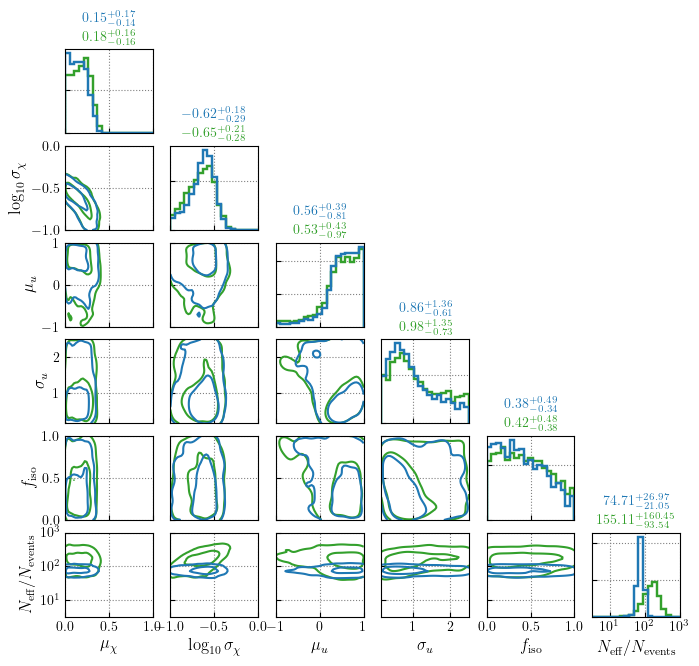

In [15]:
fig = plt.figure(figsize=(14*(6./9.)*0.85,13*(6./9.)*0.85))

bqs_inj = inj_samps.bq.values
mu_chis_inj = inj_samps.mu_chi.values
logsig_chis_inj = inj_samps.logsig_chi.values
mu_costs_inj = inj_samps.mu_cost.values
sig_costs_inj = inj_samps.sig_cost.values
f_isos_inj = inj_samps.f_iso.values
Neffs_inj = np.log10(inj_samps.nEff_inj_per_event.values)

bqs_nn = nn_samps.bq.values
mu_chis_nn = nn_samps.mu_chi.values
logsig_chis_nn = nn_samps.logsig_chi.values
mu_costs_nn = nn_samps.mu_cost.values
sig_costs_nn = nn_samps.sig_cost.values
f_isos_nn = nn_samps.f_iso.values
Neffs_nn = np.log10(nn_samps.nEff_inj_per_event.values)

bq_min,bq_max = -2,6
mu_chi_min,mu_chi_max = 0,1
logsig_chi_min,logsig_chi_max = -1,0
mu_cost_min,mu_cost_max = -1,1
sig_cost_min,sig_cost_max = 0.15,2.5
f_iso_min,f_iso_max = 0,1
Neff_min,Neff_max = 0.5,3

###########
# COLUMN 1
###########

ax = fig.add_subplot(6,6,1)
ax.hist(mu_chis_inj,density=True,histtype='step',bins=np.linspace(mu_chi_min,mu_chi_max,20),color=cnsbh,lw=1.75)
ax.hist(mu_chis_nn,density=True,histtype='step',bins=np.linspace(mu_chi_min,mu_chi_max,20),color=cbbh,lw=1.75)
ax.set_xlim(mu_chi_min,mu_chi_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(mu_chis_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(mu_chis_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(6,6,7)
plot_contour_data(ax,mu_chis_inj,logsig_chis_inj,mu_chi_min,mu_chi_max,logsig_chi_min,logsig_chi_max,cnsbh)
plot_contour_data(ax,mu_chis_nn,logsig_chis_nn,mu_chi_min,mu_chi_max,logsig_chi_min,logsig_chi_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\log_{10}\sigma_\chi$")

ax = fig.add_subplot(6,6,13)
plot_contour_data(ax,mu_chis_inj,mu_costs_inj,mu_chi_min,mu_chi_max,mu_cost_min,mu_cost_max,cnsbh)
plot_contour_data(ax,mu_chis_nn,mu_costs_nn,mu_chi_min,mu_chi_max,mu_cost_min,mu_cost_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\mu_u$")

ax = fig.add_subplot(6,6,19)
plot_contour_data(ax,mu_chis_inj,sig_costs_inj,mu_chi_min,mu_chi_max,sig_cost_min,sig_cost_max,cnsbh)
plot_contour_data(ax,mu_chis_nn,sig_costs_nn,mu_chi_min,mu_chi_max,sig_cost_min,sig_cost_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\sigma_u$")

ax = fig.add_subplot(6,6,25)
plot_contour_data(ax,mu_chis_inj,f_isos_inj,mu_chi_min,mu_chi_max,f_iso_min,f_iso_max,cnsbh)
plot_contour_data(ax,mu_chis_nn,f_isos_nn,mu_chi_min,mu_chi_max,f_iso_min,f_iso_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$f_\mathrm{iso}$")

ax = fig.add_subplot(6,6,31)
plot_contour_data(ax,mu_chis_inj,Neffs_inj,mu_chi_min,mu_chi_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,mu_chis_nn,Neffs_nn,mu_chi_min,mu_chi_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\mu_\chi$")
ax.set_yticks([1,2,3])
ax.set_yticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_ylabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")

###########
# COLUMN 2
###########

ax = fig.add_subplot(6,6,8)
ax.hist(logsig_chis_inj,density=True,histtype='step',bins=np.linspace(logsig_chi_min,logsig_chi_max,20),color=cnsbh,lw=1.75)
ax.hist(logsig_chis_nn,density=True,histtype='step',bins=np.linspace(logsig_chi_min,logsig_chi_max,20),color=cbbh,lw=1.75)
ax.set_xlim(logsig_chi_min,logsig_chi_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(logsig_chis_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(logsig_chis_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(6,6,14)
plot_contour_data(ax,logsig_chis_inj,mu_costs_inj,logsig_chi_min,logsig_chi_max,mu_cost_min,mu_cost_max,cnsbh)
plot_contour_data(ax,logsig_chis_nn,mu_costs_nn,logsig_chi_min,logsig_chi_max,mu_cost_min,mu_cost_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,20)
plot_contour_data(ax,logsig_chis_inj,sig_costs_inj,logsig_chi_min,logsig_chi_max,sig_cost_min,sig_cost_max,cnsbh)
plot_contour_data(ax,logsig_chis_nn,sig_costs_nn,logsig_chi_min,logsig_chi_max,sig_cost_min,sig_cost_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,26)
plot_contour_data(ax,logsig_chis_inj,f_isos_inj,logsig_chi_min,logsig_chi_max,f_iso_min,f_iso_max,cnsbh)
plot_contour_data(ax,logsig_chis_nn,f_isos_nn,logsig_chi_min,logsig_chi_max,f_iso_min,f_iso_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,32)
plot_contour_data(ax,logsig_chis_inj,Neffs_inj,logsig_chi_min,logsig_chi_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,logsig_chis_nn,Neffs_nn,logsig_chi_min,logsig_chi_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\log_{10}\sigma_\chi$")

###########
# COLUMN 3
###########

ax = fig.add_subplot(6,6,15)
ax.hist(mu_costs_inj,density=True,histtype='step',bins=np.linspace(mu_cost_min,mu_cost_max,20),color=cnsbh,lw=1.75)
ax.hist(mu_costs_nn,density=True,histtype='step',bins=np.linspace(mu_cost_min,mu_cost_max,20),color=cbbh,lw=1.75)
ax.set_xlim(mu_cost_min,mu_cost_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(mu_costs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(mu_costs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(6,6,21)
plot_contour_data(ax,mu_costs_inj,sig_costs_inj,mu_cost_min,mu_cost_max,sig_cost_min,sig_cost_max,cnsbh)
plot_contour_data(ax,mu_costs_nn,sig_costs_nn,mu_cost_min,mu_cost_max,sig_cost_min,sig_cost_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,27)
plot_contour_data(ax,mu_costs_inj,f_isos_inj,mu_cost_min,mu_cost_max,f_iso_min,f_iso_max,cnsbh)
plot_contour_data(ax,mu_costs_nn,f_isos_nn,mu_cost_min,mu_cost_max,f_iso_min,f_iso_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,33)
plot_contour_data(ax,mu_costs_inj,Neffs_inj,mu_cost_min,mu_cost_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,mu_costs_nn,Neffs_nn,mu_cost_min,mu_cost_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\mu_u$")

###########
# COLUMN 4
###########

ax = fig.add_subplot(6,6,22)
ax.hist(sig_costs_inj,density=True,histtype='step',bins=np.linspace(sig_cost_min,sig_cost_max,20),color=cnsbh,lw=1.75)
ax.hist(sig_costs_nn,density=True,histtype='step',bins=np.linspace(sig_cost_min,sig_cost_max,20),color=cbbh,lw=1.75)
ax.set_xlim(sig_cost_min,sig_cost_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(sig_costs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(sig_costs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(6,6,28)
plot_contour_data(ax,sig_costs_inj,f_isos_inj,sig_cost_min,sig_cost_max,f_iso_min,f_iso_max,cnsbh)
plot_contour_data(ax,sig_costs_nn,f_isos_nn,sig_cost_min,sig_cost_max,f_iso_min,f_iso_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(6,6,34)
plot_contour_data(ax,sig_costs_inj,Neffs_inj,sig_cost_min,sig_cost_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,sig_costs_nn,Neffs_nn,sig_cost_min,sig_cost_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\sigma_u$")

###########
# COLUMN 5
###########

ax = fig.add_subplot(6,6,29)
ax.hist(f_isos_inj,density=True,histtype='step',bins=np.linspace(f_iso_min,f_iso_max,20),color=cnsbh,lw=1.75)
ax.hist(f_isos_nn,density=True,histtype='step',bins=np.linspace(f_iso_min,f_iso_max,20),color=cbbh,lw=1.75)
ax.set_xlim(f_iso_min,f_iso_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(f_isos_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(f_isos_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(6,6,35)
plot_contour_data(ax,f_isos_inj,Neffs_inj,f_iso_min,f_iso_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,f_isos_nn,Neffs_nn,f_iso_min,f_iso_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$f_\mathrm{iso}$")

###########
# COLUMN 6
###########

ax = fig.add_subplot(6,6,36)
ax.hist(Neffs_inj,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cnsbh,lw=1.75)
ax.hist(Neffs_nn,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cbbh,lw=1.75)
ax.set_xlim(Neff_min,Neff_max)
ax.set_yticklabels([])
ax.set_xticks([1,2,3])
ax.set_xticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")
ax.text(0.5,1.1,get_interval_string(10.**Neffs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(10.**Neffs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)


plt.subplots_adjust(wspace=0.2,hspace=0.15)
plt.savefig('figure_11.pdf',bbox_inches='tight',dpi=400)
plt.show()

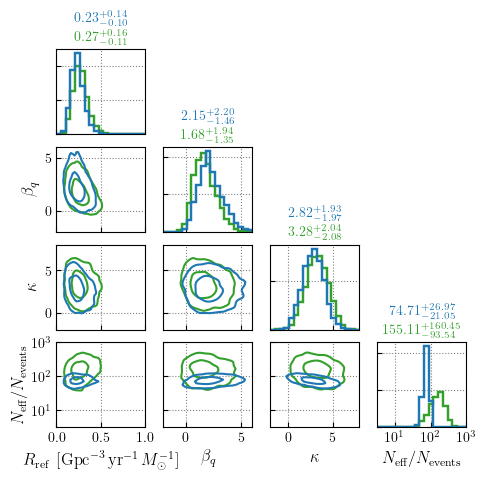

In [16]:
fig = plt.figure(figsize=(14*(4./9.)*0.85,13*(4./9.)*0.85))

bqs_inj = inj_samps.bq.values
Rs_inj = inj_samps.R20.values
kappas_inj = inj_samps.kappa.values
Neffs_inj = np.log10(inj_samps.nEff_inj_per_event.values)

bqs_nn = nn_samps.bq.values
Rs_nn = nn_samps.R20.values
kappas_nn = nn_samps.kappa.values
Neffs_nn = np.log10(nn_samps.nEff_inj_per_event.values)

bq_min,bq_max = -2,6
R_min,R_max = 0,1
kappa_min,kappa_max = -2,8
Neff_min,Neff_max = 0.5,3

###########
# COLUMN 1
###########

ax = fig.add_subplot(4,4,1)
ax.hist(Rs_inj,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color=cnsbh,lw=1.75)
ax.hist(Rs_nn,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color=cbbh,lw=1.75)
ax.set_xlim(R_min,R_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(Rs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(Rs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(4,4,5)
plot_contour_data(ax,Rs_inj,bqs_inj,R_min,R_max,bq_min,bq_max,cnsbh)
plot_contour_data(ax,Rs_nn,bqs_nn,R_min,R_max,bq_min,bq_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\beta_q$")

ax = fig.add_subplot(4,4,9)
plot_contour_data(ax,Rs_inj,kappas_inj,R_min,R_max,kappa_min,kappa_max,cnsbh)
plot_contour_data(ax,Rs_nn,kappas_nn,R_min,R_max,kappa_min,kappa_max,cbbh)
ax.set_xticklabels([])
ax.set_ylabel(r"$\kappa$")

ax = fig.add_subplot(4,4,13)
plot_contour_data(ax,Rs_inj,Neffs_inj,R_min,R_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,Rs_nn,Neffs_nn,R_min,R_max,Neff_min,Neff_max,cbbh)
ax.set_yticks([1,2,3])
ax.set_yticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel(r"$R_\mathrm{ref}$ [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}$]")
ax.set_ylabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")

###########
# COLUMN 2
###########

ax = fig.add_subplot(4,4,6)
ax.hist(bqs_inj,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color=cnsbh,lw=1.75)
ax.hist(bqs_nn,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color=cbbh,lw=1.75)
ax.set_xlim(bq_min,bq_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(bqs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(bqs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(4,4,10)
plot_contour_data(ax,bqs_inj,kappas_inj,bq_min,bq_max,kappa_min,kappa_max,cnsbh)
plot_contour_data(ax,bqs_nn,kappas_nn,bq_min,bq_max,kappa_min,kappa_max,cbbh)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(4,4,14)
plot_contour_data(ax,bqs_inj,Neffs_inj,bq_min,bq_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,bqs_nn,Neffs_nn,bq_min,bq_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\beta_q$")

###########
# COLUMN 3
###########

ax = fig.add_subplot(4,4,11)
ax.hist(kappas_inj,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color=cnsbh,lw=1.75)
ax.hist(kappas_nn,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color=cbbh,lw=1.75)
ax.set_xlim(kappa_min,kappa_max)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.5,1.1,get_interval_string(kappas_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(kappas_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)

ax = fig.add_subplot(4,4,15)
plot_contour_data(ax,kappas_inj,Neffs_inj,kappa_min,kappa_max,Neff_min,Neff_max,cnsbh)
plot_contour_data(ax,kappas_nn,Neffs_nn,kappa_min,kappa_max,Neff_min,Neff_max,cbbh)
ax.set_yticklabels([])
ax.set_xlabel(r"$\kappa$")

###########
# COLUMN 4
###########

ax = fig.add_subplot(4,4,16)
ax.hist(Neffs_inj,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cnsbh,lw=1.75)
ax.hist(Neffs_nn,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cbbh,lw=1.75)
ax.set_xlim(Neff_min,Neff_max)
ax.set_yticklabels([])
ax.set_xticks([1,2,3])
ax.set_xticklabels(["$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")
ax.text(0.5,1.1,get_interval_string(10.**Neffs_inj),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cnsbh)
ax.text(0.5,1.325,get_interval_string(10.**Neffs_nn),
        transform=ax.transAxes,
        horizontalalignment='center',
        color=cbbh)


plt.subplots_adjust(wspace=0.2,hspace=0.15)
plt.savefig('figure_12.pdf',bbox_inches='tight',dpi=400)
plt.show()

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_47696/3043954333.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["$10^{0.5}$","$10^{1}$","$10^{1.75}$","$10^{2}$"])
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_47696/3043954333.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["$10$","$10^{2}$"])


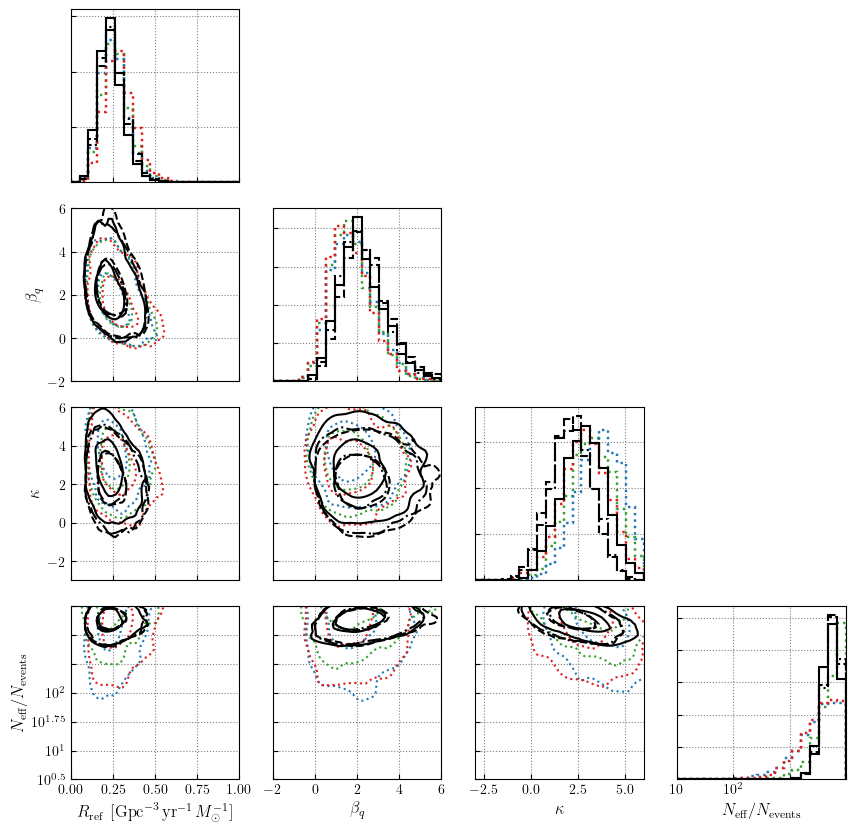

In [19]:
fig = plt.figure(figsize=(10,10))

bqs_inj = inj_samps.bq.values
Rs_inj = inj_samps.R20.values
kappas_inj = inj_samps.kappa.values
Neffs_inj = np.log10(inj_samps.nEff_inj_per_event.values)

bqs_injA = injA_samps.bq.values
Rs_injA = injA_samps.R20.values
kappas_injA = injA_samps.kappa.values
Neffs_injA = np.log10(injA_samps.nEff_inj_per_event.values)

bqs_injB = injB_samps.bq.values
Rs_injB = injB_samps.R20.values
kappas_injB = injB_samps.kappa.values
Neffs_injB = np.log10(injB_samps.nEff_inj_per_event.values)

bqs_nn = nn_samps.bq.values
Rs_nn = nn_samps.R20.values
kappas_nn = nn_samps.kappa.values
Neffs_nn = np.log10(nn_samps.nEff_inj_per_event.values)

bqs_nnA = nnA_samps.bq.values
Rs_nnA = nnA_samps.R20.values
kappas_nnA = nnA_samps.kappa.values
Neffs_nnA = np.log10(nnA_samps.nEff_inj_per_event.values)

bqs_nnB = nnB_samps.bq.values
Rs_nnB = nnB_samps.R20.values
kappas_nnB = nnB_samps.kappa.values
Neffs_nnB = np.log10(nnB_samps.nEff_inj_per_event.values)

bq_min,bq_max = -2,6
R_min,R_max = 0,1
kappa_min,kappa_max = -3,6
Neff_min,Neff_max = 0.5,2

###########
# COLUMN 1
###########

ax = fig.add_subplot(4,4,1)
ax.hist(Rs_inj,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color=cnsbh,lw=1.75,ls=':')
ax.hist(Rs_injA,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color=cbbh,lw=1.75,ls=':')
ax.hist(Rs_injB,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color=cbns,lw=1.75,ls=':')
ax.hist(Rs_nn,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color='black',lw=1.5)
ax.hist(Rs_nnA,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color='black',lw=1.5,ls='--')
ax.hist(Rs_nnB,density=True,histtype='step',bins=np.linspace(R_min,R_max,20),color='black',lw=1.5,ls='-.')
ax.set_xlim(R_min,R_max)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(4,4,5)
plot_contour_data(ax,Rs_inj,bqs_inj,R_min,R_max,bq_min,bq_max,cnsbh,ls=':')
plot_contour_data(ax,Rs_injA,bqs_injA,R_min,R_max,bq_min,bq_max,cbbh,ls=':')
plot_contour_data(ax,Rs_injB,bqs_injB,R_min,R_max,bq_min,bq_max,cbns,ls=':')
plot_contour_data(ax,Rs_nn,bqs_nn,R_min,R_max,bq_min,bq_max,'black')
plot_contour_data(ax,Rs_nnA,bqs_nnA,R_min,R_max,bq_min,bq_max,'black',ls='--')
plot_contour_data(ax,Rs_nnB,bqs_nnB,R_min,R_max,bq_min,bq_max,'black',ls='-.')
ax.set_xticklabels([])
ax.set_ylabel(r"$\beta_q$")

ax = fig.add_subplot(4,4,9)
plot_contour_data(ax,Rs_inj,kappas_inj,R_min,R_max,kappa_min,kappa_max,cnsbh,ls=':')
plot_contour_data(ax,Rs_injA,kappas_injA,R_min,R_max,kappa_min,kappa_max,cbbh,ls=':')
plot_contour_data(ax,Rs_injB,kappas_injB,R_min,R_max,kappa_min,kappa_max,cbns,ls=':')
plot_contour_data(ax,Rs_nn,kappas_nn,R_min,R_max,kappa_min,kappa_max,'black')
plot_contour_data(ax,Rs_nnA,kappas_nnA,R_min,R_max,kappa_min,kappa_max,'black',ls='--')
plot_contour_data(ax,Rs_nnB,kappas_nnB,R_min,R_max,kappa_min,kappa_max,'black',ls='-.')
ax.set_xticklabels([])
ax.set_ylabel(r"$\kappa$")

ax = fig.add_subplot(4,4,13)
plot_contour_data(ax,Rs_inj,Neffs_inj,R_min,R_max,Neff_min,Neff_max,cnsbh,ls=':')
plot_contour_data(ax,Rs_injA,Neffs_injA,R_min,R_max,Neff_min,Neff_max,cbbh,ls=':')
plot_contour_data(ax,Rs_injB,Neffs_injB,R_min,R_max,Neff_min,Neff_max,cbns,ls=':')
plot_contour_data(ax,Rs_nn,Neffs_nn,R_min,R_max,Neff_min,Neff_max,'black')
plot_contour_data(ax,Rs_nnA,Neffs_nnA,R_min,R_max,Neff_min,Neff_max,'black',ls='--')
plot_contour_data(ax,Rs_nnB,Neffs_nnB,R_min,R_max,Neff_min,Neff_max,'black',ls='-.')
ax.set_yticklabels(["$10^{0.5}$","$10^{1}$","$10^{1.75}$","$10^{2}$"])
ax.set_xlabel(r"$R_\mathrm{ref}$ [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}$]")
ax.set_ylabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")

###########
# COLUMN 2
###########

ax = fig.add_subplot(4,4,6)
ax.hist(bqs_inj,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color=cnsbh,lw=1.75,ls=':')
ax.hist(bqs_injA,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color=cbbh,lw=1.75,ls=':')
ax.hist(bqs_injB,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color=cbns,lw=1.75,ls=':')
ax.hist(bqs_nn,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color='black',lw=1.5)
ax.hist(bqs_nnA,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color='black',lw=1.5,ls='--')
ax.hist(bqs_nnB,density=True,histtype='step',bins=np.linspace(bq_min,bq_max,20),color='black',lw=1.5,ls='-.')
ax.set_xlim(bq_min,bq_max)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(4,4,10)
plot_contour_data(ax,bqs_inj,kappas_inj,bq_min,bq_max,kappa_min,kappa_max,cnsbh,ls=':')
plot_contour_data(ax,bqs_injA,kappas_injA,bq_min,bq_max,kappa_min,kappa_max,cbbh,ls=':')
plot_contour_data(ax,bqs_injB,kappas_injB,bq_min,bq_max,kappa_min,kappa_max,cbns,ls=':')
plot_contour_data(ax,bqs_nn,kappas_nn,bq_min,bq_max,kappa_min,kappa_max,'black')
plot_contour_data(ax,bqs_nnA,kappas_nnA,bq_min,bq_max,kappa_min,kappa_max,'black',ls='--')
plot_contour_data(ax,bqs_nnB,kappas_nnB,bq_min,bq_max,kappa_min,kappa_max,'black',ls='-.')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(4,4,14)
plot_contour_data(ax,bqs_inj,Neffs_inj,bq_min,bq_max,Neff_min,Neff_max,cnsbh,ls=':')
plot_contour_data(ax,bqs_injA,Neffs_injA,bq_min,bq_max,Neff_min,Neff_max,cbbh,ls=':')
plot_contour_data(ax,bqs_injB,Neffs_injB,bq_min,bq_max,Neff_min,Neff_max,cbns,ls=':')
plot_contour_data(ax,bqs_nn,Neffs_nn,bq_min,bq_max,Neff_min,Neff_max,'black')
plot_contour_data(ax,bqs_nnA,Neffs_nnA,bq_min,bq_max,Neff_min,Neff_max,'black',ls='--')
plot_contour_data(ax,bqs_nnB,Neffs_nnB,bq_min,bq_max,Neff_min,Neff_max,'black',ls='-.')
ax.set_yticklabels([])
ax.set_xlabel(r"$\beta_q$")

###########
# COLUMN 3
###########

ax = fig.add_subplot(4,4,11)
ax.hist(kappas_inj,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color=cnsbh,lw=1.75,ls=':')
ax.hist(kappas_injA,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color=cbbh,lw=1.75,ls=':')
ax.hist(kappas_injB,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color=cbns,lw=1.75,ls=':')
ax.hist(kappas_nn,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color='black',lw=1.5)
ax.hist(kappas_nnA,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color='black',lw=1.5,ls='--')
ax.hist(kappas_nnB,density=True,histtype='step',bins=np.linspace(kappa_min,kappa_max,20),color='black',lw=1.5,ls='-.')
ax.set_xlim(kappa_min,kappa_max)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(4,4,15)
plot_contour_data(ax,kappas_inj,Neffs_inj,kappa_min,kappa_max,Neff_min,Neff_max,cnsbh,ls=':')
plot_contour_data(ax,kappas_injA,Neffs_injA,kappa_min,kappa_max,Neff_min,Neff_max,cbbh,ls=':')
plot_contour_data(ax,kappas_injB,Neffs_injB,kappa_min,kappa_max,Neff_min,Neff_max,cbns,ls=':')
plot_contour_data(ax,kappas_nn,Neffs_nn,kappa_min,kappa_max,Neff_min,Neff_max,'black')
plot_contour_data(ax,kappas_nnA,Neffs_nnA,kappa_min,kappa_max,Neff_min,Neff_max,'black',ls='--')
plot_contour_data(ax,kappas_nnB,Neffs_nnB,kappa_min,kappa_max,Neff_min,Neff_max,'black',ls='-.')
ax.set_yticklabels([])
ax.set_xlabel(r"$\kappa$")

###########
# COLUMN 4
###########

ax = fig.add_subplot(4,4,16)
ax.hist(Neffs_inj,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cnsbh,lw=1.75,ls=':')
ax.hist(Neffs_injA,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cbbh,lw=1.75,ls=':')
ax.hist(Neffs_injB,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color=cbns,lw=1.75,ls=':')
ax.hist(Neffs_nn,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color='black',lw=1.5)
ax.hist(Neffs_nnA,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color='black',lw=1.5,ls='--')
ax.hist(Neffs_nnB,density=True,histtype='step',bins=np.linspace(Neff_min,Neff_max,20),color='black',lw=1.5,ls='-.')
ax.set_xlim(Neff_min,Neff_max)
ax.set_yticklabels([])
ax.set_xticklabels(["$10$","$10^{2}$"])
ax.set_xlabel(r"$N_\mathrm{eff}/N_\mathrm{events}$")


plt.subplots_adjust(wspace=0.2,hspace=0.15)
#plt.savefig('figure_12.pdf',bbox_inches='tight',dpi=400)
plt.show()